# Parallelization

## Notes on Parallelization in Turing.jl

`~` is only thread safe for observations not assumptions: https://github.com/TuringLang/Turing.jl/blob/master/HISTORY.md

This makes sampling from the prior a bit difficult, since we need to fill the observation with an assumption.
However, the following macro can be used to disable threading depending on a condition. Usage:

```julia
@maybethreads <condition> for ...
```

## Install multi-threaded kernel

```julia
using Pkg
Pkg.activate("")
using IJulia
IJulia.installkernel("Julia 6 Threads", env=Dict(
    "JULIA_NUM_THREADS" => "6",
))
```

In [1]:
using Base.Threads
macro maybethreads(cond, ex)
    return esc(:($cond ? (@threads $ex) : $ex))
end

@maybethreads (macro with 1 method)

In [2]:
@maybethreads true for i in 1:10
    print("$i ")
end
Threads.nthreads()

7 9 10 5 3 1 8 4 6 2 

6

# Setup Environment
Using vscode with a custom kernel might result in the X11 DISPLAY variable not being found.
The easiest workaround is to start an external kernel, for example via `jupyter-server`.

In [18]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using MCMCDepth
using GLAbstraction, GLFW, SciGL
# TODO How to avoid adding them (automatically install / use with SciGL.jl)
using LinearAlgebra, CoordinateTransformations, Rotations
using Images
using Soss, MeasureTheory
using TransformVariables
using BenchmarkTools, DataFrames, StatsPlots
plotly()

  Activating environment at `~/code/mcmc-depth-images/Project.toml`
Precompiling project...
  ✓ BenchmarkTools
  ✓ Soss
  ✓ Plots
  ✓ StatsPlots
  ✓ MCMCDepth
  5 dependencies successfully precompiled in 56 seconds (340 already precompiled)
┌ Info: Precompiling Soss [8ce77f84-9b61-11e8-39ff-d17a774bf41c]
└ @ Base loading.jl:1342
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/rd/.julia/packages/Plots/PomtQ/src/backends.jl:432


Plots.PlotlyBackend()

# Initialize the **OpenGL** offscreen render context


In [19]:
const WIDTH = 150
const HEIGHT = 150
# Create the GLFW window. This sets all the hints and makes the context current.
window = context_offscreen(WIDTH, HEIGHT)
# Buffer
framebuffer = depth_framebuffer(WIDTH, HEIGHT)
enable_depth_stencil()
set_clear_color()
# Shader Program
depth_prog = GLAbstraction.Program(SimpleVert, DepthFrag);

Load the the camera and mesh. Wrap them in a scene for simplified rendering.


In [20]:
camera = CvCamera(WIDTH, HEIGHT, 1.2 * WIDTH, 1.2 * HEIGHT, WIDTH / 2, HEIGHT / 2) |> SceneObject
monkey = load_mesh(depth_prog, "meshes/monkey.obj") |> SceneObject
cube = load_mesh(depth_prog, "meshes/cube.obj") |> SceneObject
scene = Scene(camera, [monkey]);
cube_scene = Scene(camera, [monkey, cube]);

In [21]:
function render_depth(scene::Scene)
    GLAbstraction.bind(framebuffer)
    clear_buffers()
    draw(depth_prog, scene)
    # load float values
    img = channelview(gpu_data(framebuffer, 1))
    transpose(img[:,end:-1:1])
end;

# Render the nominal scene
This is the scene without any noise in the pose or sensor.

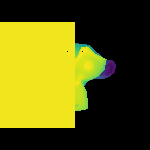

In [22]:
t = [0, 0, 2.0]
cov_t = [0.1 0 0; 0 0.1 0; 0 0 0.1]
r = [0, π, 0]
monkey.pose.t = Translation(t)
monkey.pose.R = RotZYX(r...)
cube.pose.t = Translation(t + [0.5, 0, 0.2])
camera.pose.R = lookat(camera, monkey, [0, 1, 0]);
nominal_depth = render_depth(cube_scene)
colorize_depth(nominal_depth)

# Probabilistic Model


Soss expects a symbol on the left side -> workaround is to encapsulate everything in one function. This also cleans up the code.


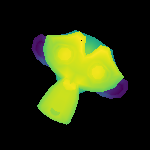

In [23]:
function render_pose_depth(scene, t, r)
    scene.meshes[1].pose.t = Translation(t)
    scene.meshes[1].pose.R = RotZYX(r...)
    render_depth(scene)
end
pose_depth = render_pose_depth(scene, t + [0, 0, -0.5], r + [0.5, 0, 0])
colorize_depth(pose_depth)

Describes how the data is generated given:

- A `scene` with all relevant object, the first object is assumed to be the object of interest
- The RFID measurement for the position with the mean and covariance `mean_t` & `cov_t`
- The model will be conditioned on the depth image `y`


In [24]:
# TODO  must be handled by preprocessing
const MAX_DEPTH = 2.0
const PIXEL_σ = 0.01
# θ=1/λ
const PIXEL_θ = 1 / 0.5
const ZERO_IMG = zeros(WIDTH, HEIGHT);

Handle outliers ∉[0,MAX_DEPTH]

In [25]:
function preprocess(render, obs, occl)
    # Use only the nonzero values of the render for the likelihood
    indices = findall(!iszero, render)
    obs_sel = obs[indices]
    render_sel = render[indices]
    occl_sel = occl[indices]
    # Convention for invalid values: depth=0
    obs_limits = [ifelse(0 <= x <= MAX_DEPTH, x, zero(x)) for x in obs_sel]
    render_sel, obs_limits, occl_sel
end
render_prep, obs_prep, _ = preprocess(nominal_depth, pose_depth, zeros(size(nominal_depth)))
colorize_depth(obs_prep)

In [26]:
colorize_depth(render_prep)

In [27]:
prior_model = @model mean_t, cov_t begin
    # Sample position from RFID position
    t ~ MvNormal(mean_t, cov_t)
    # We don't know anything about the orientation or the occlusion
    r ~ For(1:3) do _ CircularUniform() end
    o .~ UniformInterval.(ZERO_IMG, 1)
end
θ1 = rand(prior_model(mean_t=t, cov_t=cov_t))
μ1 = render_pose_depth(scene, θ1.t, θ1.r)
μ1_prep, obs_prep, o_prep = preprocess(μ1, nominal_depth, θ1.o)
colorize_depth(μ1_prep)

In [28]:
colorize_depth(obs_prep)

In [29]:
colorize_depth(o_prep)

Old model required the `UniformInterval` as fix for the missing values, not very robust.
Moreover, the occlusion `Mixture` can be marginalized analytically, which is 

In [30]:
old_observation_model = @model μ, o begin
    # Sensor model
    occluded .~ MeasureTheory.Bernoulli.(o)
    obs ~ For(eachindex(μ)) do i
        if (μ[i] != 0)
            if occluded[i]
                Exponential(PIXEL_θ)
            else
                Normal(μ[i], PIXEL_σ)
            end
        else
            UniformInterval(0, MAX_DEPTH)
        end
    end
end;

-1.0097333178735995e6

In [45]:
observation_model = @model μ, o begin
    obs ~ For(eachindex(μ)) do i
        MixtureMeasure([Exponential(PIXEL_θ), Normal(μ[i], PIXEL_σ)], [o[i], 1 - o[i]])
    end
end;
colorize_depth(rand(observation_model(μ = μ1_prep, o = o_prep)).obs)

# Benchmark observation models
- The new model requires some preprocessing but the logdensity can be calculated analytically without extra sampling
- The old model requires to sample the occlusion state and does not support preprocessing, or does it?

**New model is x2 faster**, requires less allocations and is exact instead of sampling occlusion realizations

In [42]:
@benchmark begin
    μ1_prep, obs_prep, o_prep = preprocess(μ1, nominal_depth, θ1.o)
    logdensity(observation_model(μ = μ1_prep, o = o_prep) | (; obs = obs_prep))
end

BenchmarkTools.Trial: 2102 samples with 1 evaluation.
 Range (min … max):  1.865 ms … 25.225 ms  ┊ GC (min … max):  0.00% … 81.36%
 Time  (median):     2.040 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.371 ms ±  2.050 ms  ┊ GC (mean ± σ):  11.83% ± 11.95%

  █▄▁                                                         
  ███▇▆▅▄▁▃▁▅▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇ █
  1.86 ms      Histogram: log(frequency) by time     16.4 ms <

 Memory estimate: 2.16 MiB, allocs estimate: 56899.

In [44]:
old_observation_prior = prior(old_observation_model, :obs)
@benchmark begin
    occluded_old = rand(old_observation_prior(μ = μ1, o = θ1.o)).occluded
    logdensity(old_observation_model(μ = μ1, o = θ1.o) | (; occluded = occluded_old, obs = nominal_depth))
end

BenchmarkTools.Trial: 1549 samples with 1 evaluation.
 Range (min … max):  2.690 ms … 11.733 ms  ┊ GC (min … max): 0.00% … 69.86%
 Time  (median):     2.973 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.221 ms ±  1.145 ms  ┊ GC (mean ± σ):  4.82% ± 10.06%

  ▂█▇▅▄▃▁                                                     
  ███████▆▆▅▅▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▄▄▃▇ █
  2.69 ms      Histogram: log(frequency) by time     10.6 ms <

 Memory estimate: 2.37 MiB, allocs estimate: 71190.

In [16]:
const PROPOSAL_σ_t = [0.01, 0.01, 0.01]
const PROPOSAL_σ_r = [0.1, 0.1, 0.1]
const PROPOSAL_σ_o = fill(0.5, WIDTH, HEIGHT);

In [17]:
proposal_model = @model scene, mean_t, cov_t begin
    # Sample position from RFID position
    t .~ Normal.(0, PROPOSAL_σ_t)
    # We don't know anything about the orientation or the occlusion
    r .~ Normal.(0, PROPOSAL_σ_r)
    occluded .~ Normal.(0, PROPOSAL_σ_o)
end;
rand(proposal_model)

(t = [3.569139966483192e-5, -0.013775202737350375, 0.006855270888988426], r = [-0.22423628122217754, 0.05335684296459116, -0.11003427827968992], occluded = [0.3462719640279129 0.26741092036141056 … -1.2815008586675667 0.1947697907857052; 0.29940093677489166 0.3826955064565068 … 0.3433931432328626 0.1981196384964314; … ; 0.24613677867068917 0.2576797970043603 … 0.6865557911895772 0.1315562838182559; 0.39029837805360534 -0.010443715032628951 … 0.4072683317104815 -0.6491087219747755])

# Metropolis Hastings implementation
Store the required variables in a struct:
- `m`: the full model
- `proposals`: variables to propose, other variables are sampled via ancestral sampling
- `data`: fit the model parameters to these observations
- `q`: model for the variables in `proposals`, e.g. before(m, (:a, :b))(args)
- `f`: model for the internal variables, must not include observations, moves params to args, e.g. predictive(m, (:a, :b))(args)
- `ℓ`: logdensity for the model parameters θ conditioned on the data, e.g. ℓ(θ)=logdensity(m(args) | data, θ)

In [ ]:
# Immutable for a given set of args and parameters -> new data new MetropolisHastings
struct MetropolisHastings
    m::Soss.AbstractModel
    propsals::Tuple
    data::NamedTuple 
    q::Soss.ConditionalModel
    f::Soss.ConditionalModel
    ℓ::Function
end

function MetropolisHastings(m::Soss.Model, args::NamedTuple, proposals::Tuple, data::NamedTuple)
    # only proposal variables
    q = Soss.before(m, proposals...)(args)
    # other variables except observations, moves params to args
    f = prior(predictive(m, proposals...), keys(data)...)(args)
    # function to calculate the loglikelihood
    ℓ(θ) = logdensity(m(args) | data, θ)
    MetropolisHastings(m, proposals, data, q, f, ℓ)
end

args = (;scene=scene, mean_t=t, cov_t=cov_t)
proposals = (:t, :r_uniform, :occ_prob)
data = (;y=nominal_depth)
mh = MetropolisHastings(depth_model, args, proposals, data);

# Proposals
## Prior Proposal
Draws a random sample from the prior distribution. Results in a worse acceptance rate, if the posterior is focused on a small parameter space.

In [ ]:
function propose_prior(mh::MetropolisHastings)
  ## propose, predict, concatenate, weight
  s1 = rand(mh.q)
  s2 = rand(mh.f(s1))
  s = (;s1..., s2...)
  Weighted(mh.ℓ(s), s)
end
s1 = propose_prior(mh)
s2 = propose_prior(mh);

# Gaussian Proposal
Propose a new sample from the old sample `s` by sampling using a normal distribution centered around the value of the old parameter.
Might lead to a higher acceptance rate for focused posteriors.
Current implementation is brittle: If the parameters are bounded, e.g. $\lambda$ of a Poisson distribution. Mature libraries like Turing.jl typically take care of this by transforming variables to the space of all real numbers and back to the constrained space.

# TODO does not work yet, probably the occlusion
```julia
function propose_normal(mh::MetropolisHastings, s::Weighted, σ=0.01)
  old_sample = s.val
  s1 = (;)
  for (k, v) in pairs(old_sample)
    # Other variables are sampled via f
    if k in mh.propsals
      # TODO parameter values might become invalid (i.e. negative for poisson)
      new_val = rand.(Normal.(v, σ))
      # if the parameter is an integer, the new one should also be
      if v isa Int
        new_val = Int(round(new_v))
      end
      s1 = merge(s1, (;k => new_val))
    end
  end
  s2 = rand(mh.f(s1))
  s = (;s1..., s2...)
  Weighted(mh.ℓ(s), s)
end
s2 = propose_normal(mh, s1, 2)
```

# Kernels
Returns either the `old_sample` or the `new_sample` depending on their probability and the `acceptance` rate $\in [0,1]$ . Simplified by using a normal distribution for the proposal, which is symmetric.

In [ ]:
function mh_symmetric_kernel(old_sample::Weighted, new_sample::Weighted)
  u = rand(Uniform())
  # Mind the log-domain: division becomes subtraction
  if log(u) > new_sample.ℓ - old_sample.ℓ
    # reject
    return old_sample
  else
    # accept (always the case if difference positive since log([0,1])->[-inf,0])
    return new_sample
  end
end
mh_symmetric_kernel(s1, s2);

# Evaluation

In [ ]:
function sample_chain(;num_samples = 1_000, use_threads=true)
    chain = [propose_prior(mh)]
    lk = SpinLock()
    @maybethreads use_threads for _ in 2:num_samples
        lock(lk)
        try
            new_sample = last(chain)
        finally
            unlock(lk)
        end
        # worse mixing than normal
        new_sample = propose_prior(mh)
        new_sample = mh_symmetric_kernel(last(chain), new_sample)
        lock(lk)
        try
            push!(chain, new_sample)
        finally
            unlock(lk)
        end
    end
    chain
end;

In [ ]:
chain = sample_chain(num_samples = 20_000, use_threads=true)

# Plots
A sample is a tuple of the log-likelihood and the vales. Therefore, create a new dataframe, which has the likelihood in the same row as the samples value.

In [ ]:
df_c = DataFrame(chain)
df = DataFrame(df_c.val)
df[!,:ℓ] = df_c.ℓ;

In [ ]:
t_samples = hcat(df.t...)'
l1 = plot(t_samples[:,1], title="t[1] samples")
d1 = StatsPlots.density(t_samples[:,1], title="t[1] density")
l2 = plot(t_samples[:,2], title="t[2] samples")
d2 = StatsPlots.density(t_samples[:,2], title="t[2] density")
l3 = plot(t_samples[:,3], title="t[3] samples")
d3 = StatsPlots.density(t_samples[:,3], title="t[3] density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2), legend=false)

In [ ]:
r_samples = hcat(df.r...)'
l1 = plot(r_samples[:,1], title="r[1] samples")
d1 = StatsPlots.density(r_samples[:,1], title="r[1] density")
l2 = plot(r_samples[:,2], title="r[2] samples")
d2 = StatsPlots.density(r_samples[:,2], title="r[2] density")
l3 = plot(r_samples[:,3], title="r[3] samples")
d3 = StatsPlots.density(r_samples[:,3], title="r[3] density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2), legend=false)

In [ ]:
colorview(Gray, mean(df.occ_prob))

# Benchmark Broadcasting vs Loop


In [ ]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
@benchmark sample_chain(num_samples = 5_000, use_threads=false)

In [ ]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
@benchmark sample_chain(num_samples = 5_000, use_threads=true)

# Scratchpad

In [ ]:
simple_depth_model = @model scene, mean_t, cov_t begin
    # Sample position from RFID position
    t ~ MvNormal(mean_t, cov_t)
    # We don't know anything about the orientation
    r ~ For(1:3) do _ Uniform(0, 2π) end
    
    # Render scene
    μ = render_pose_depth(scene, t, r)

    # sensor model
    y ~ For(eachindex(μ)) do i
        Normal(μ[i], 0.1)
    end
end;